In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2022-10-04 23:32:39--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv’

AER_credit_card_dat 100%[===================>]  71.53K  --.-KB/s    in 0.01s   

2022-10-04 23:32:40 (7.19 MB/s) - ‘AER_credit_card_data.csv’ saved [73250/73250]



In [5]:
df= pd.read_csv('AER_credit_card_data.csv')

In [6]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [7]:
df_used= df.copy()

In [8]:
df_used.dtypes

card            object
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [9]:
df_used.card = (df_used['card']=='yes').astype(int)

In [10]:
df_used.dtypes

card             int64
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [11]:
df_full_train, df_test = train_test_split(df_used, test_size=0.20, random_state= 1)

In [12]:
len(df_full_train), len(df_used), len(df_test)

(1055, 1319, 264)

In [13]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state= 1)

In [14]:
len(df_full_train), len(df_used), len(df_test), len(df_train), len(df_val)

(1055, 1319, 264, 791, 264)

In [15]:
df_full_train= df_full_train.reset_index(drop= True)

df_train= df_train.reset_index(drop= True)

df_test= df_test.reset_index(drop= True)

df_val= df_val.reset_index(drop= True)

In [16]:
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [17]:
df_train.dtypes

numerical = ['reports','age','income','share', 'expenditure','dependents','months','majorcards', 'active']

# Q1

In [18]:
score={}
for n in numerical:
    if n == 'reports':
        s=roc_auc_score(df_train.card, -df_train[n])
        score[n]= s
    else:
        s=roc_auc_score(df_train.card, df_train[n])
        score[n]= s

In [19]:
score

{'reports': 0.7166629860689376,
 'age': 0.4759979020592945,
 'income': 0.5908049467233478,
 'share': 0.989183643423692,
 'expenditure': 0.991042345276873,
 'dependents': 0.46722427722262094,
 'months': 0.470578221903237,
 'majorcards': 0.5343859842838476,
 'active': 0.6043173411362006}

Answer is share

In [20]:

from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction import DictVectorizer

In [21]:
categorical= ['owner', 'selfemp']

# Q2

In [22]:
def train_logistic(df):
    dicts_train = df[categorical+numerical].to_dict(orient='records')
    dv= DictVectorizer(sparse=False)
    X_train= dv.fit_transform(dicts_train)
    y_train= df.card.values
    model= LogisticRegression(solver='liblinear', C=1.0, max_iter= 1000)
    model.fit(X_train, y_train)
    
    return X_train, y_train,dv, model

In [23]:
def predicition_logistic(df,dv, model):
    dicts_val = df[categorical+numerical].to_dict(orient='records')
    X_val= dv.transform(dicts_val)
    y_predict= model.predict_proba(X_val)
    
    return y_predict

In [24]:
X_train, y_train , dv,  model1 = train_logistic(df_train)

In [25]:
y_pred = predicition_logistic(df_val,dv, model1)

In [26]:
y_pred= y_pred[:,1]

In [27]:
y_pred

array([1.00000000e+00, 5.80231603e-02, 1.00000000e+00, 1.95534636e-02,
       1.00000000e+00, 1.00000000e+00, 7.01198840e-02, 1.00000000e+00,
       1.00000000e+00, 9.95731859e-01, 1.38364925e-01, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.38123529e-02,
       1.00000000e+00, 1.00000000e+00, 2.32127984e-01, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 2.85316595e-04,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.17336210e-08, 4.51764765e-04, 1.00000000e+00, 4.44723906e-03,
       1.65674798e-05, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 4.81355803e-04, 1.00000000e+00, 1.00000000e+00,
       3.66674687e-03, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.71474291e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 4.42068351e-04,
      

In [28]:
y_val = df_val.card.values
roc_auc_score(y_val,y_pred).round(3)

0.995

Answer = 0.995

In [29]:
th= np.linspace(0,1,101)


In [30]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

In [31]:
scores=[]
for t in th : 
    actual_pos_valu = (y_val==1)
    actual_neg_valu= (y_val==0)
    predict_pos_valu = (y_pred>=t)
    predict_neg_valu=(y_pred<t)
    
    tp = (actual_pos_valu & predict_pos_valu).sum()
    tn = (actual_neg_valu & predict_neg_valu).sum()
    
    fp= (actual_neg_valu&predict_pos_valu).sum()
    fn=(actual_pos_valu&predict_neg_valu).sum()
    
    scores.append((t, tp , fp, fn, tn))

In [32]:
col = ['threshold', 'tp', 'fp', 'fn','tn' ]
df_scores= pd.DataFrame(scores , columns = col)

In [33]:
df_scores

,threshold,tp,fp,fn,tn
0,0.00,211,53,0,0
1,0.01,211,34,0,19
2,0.02,211,31,0,22
3,0.03,211,24,0,29
4,0.04,211,22,0,31
...,...,...,...,...,...
96,0.96,204,0,7,53
97,0.97,203,0,8,53
98,0.98,203,0,8,53
99,0.99,202,0,9,53


In [34]:
df_scores['tp'][2]

211

# Q3

In [35]:
def preci (df):
    prec=[]
    for n in range(df.shape[0]):
        percision= (df['tp'][n]/(df['tp'][n] + df['fp'][n]))
        prec.append(percision)
    return prec 

In [36]:
preci_columns= preci(df_scores)

In [37]:
df_scores['precision']=preci_columns

In [38]:
df_scores

,threshold,tp,fp,fn,tn,precision
0,0.00,211,53,0,0,0.799242
1,0.01,211,34,0,19,0.861224
2,0.02,211,31,0,22,0.871901
3,0.03,211,24,0,29,0.897872
4,0.04,211,22,0,31,0.905579
...,...,...,...,...,...,...
96,0.96,204,0,7,53,1.000000
97,0.97,203,0,8,53,1.000000
98,0.98,203,0,8,53,1.000000
99,0.99,202,0,9,53,1.000000


In [39]:
def reca (df):
    reca=[]
    for n in range(df.shape[0]):
        recall= (df['tp'][n]/(df['tp'][n] + df['fn'][n]))
        reca.append(recall)
    return reca

In [40]:
reca_col = reca(df_scores)

In [41]:
df_scores['recall']= reca_col

In [42]:
df_scores

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,211,53,0,0,0.799242,1.000000
1,0.01,211,34,0,19,0.861224,1.000000
2,0.02,211,31,0,22,0.871901,1.000000
3,0.03,211,24,0,29,0.897872,1.000000
4,0.04,211,22,0,31,0.905579,1.000000
...,...,...,...,...,...,...,...
96,0.96,204,0,7,53,1.000000,0.966825
97,0.97,203,0,8,53,1.000000,0.962085
98,0.98,203,0,8,53,1.000000,0.962085
99,0.99,202,0,9,53,1.000000,0.957346


In [43]:
from matplotlib import pyplot as plt

In [44]:
def perci_reca_curve(df):
    for n in range(df.shape[0]):
        plt.plot(df['precision'][n], df['recall'][n], label= str(n))
    

In [45]:
from shapely.geometry import MultiLineString

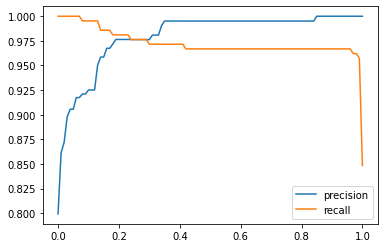

In [46]:
plt.plot(df_scores['threshold'] ,df_scores['precision'], label= 'precision')
plt.plot(df_scores['threshold'] ,df_scores['recall'],  label= 'recall')

plt.legend()

In [47]:
precis, recal, thresh =precision_recall_curve(y_val,y_pred)

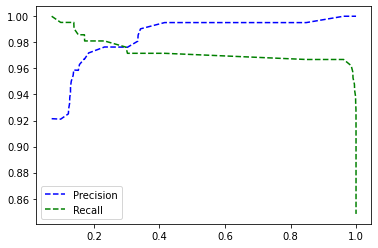

In [48]:
plt.plot(thresh, precis[:-1], "b--", label="Precision")
plt.plot(thresh, recal[:-1], "g--", label="Recall")

plt.legend()

Answer is 0.3

# Q4 

In [49]:
def f_one(df):
    fone=[]
    for f in range(df.shape[0]):
        f1= 2* ((df['precision'][f] * df['recall'][f]) /(df['precision'][f] +df['recall'][f]))
        fone.append(f1)
    return fone

In [50]:
fone_col = f_one(df_scores)

df_scores['f_one']= fone_col

In [51]:
df_scores[df_scores['f_one']==df_scores['f_one'].max()]

,threshold,tp,fp,fn,tn,precision,recall,f_one
35,0.35,205,1,6,52,0.995146,0.971564,0.983213
36,0.36,205,1,6,52,0.995146,0.971564,0.983213
37,0.37,205,1,6,52,0.995146,0.971564,0.983213
38,0.38,205,1,6,52,0.995146,0.971564,0.983213
39,0.39,205,1,6,52,0.995146,0.971564,0.983213
40,0.40,205,1,6,52,0.995146,0.971564,0.983213
41,0.41,205,1,6,52,0.995146,0.971564,0.983213


Answer is 0.4

# Q5

In [52]:
from sklearn.model_selection import KFold

In [76]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores= []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train2 = df_full_train.iloc[train_idx]
    
    df_val2= df_full_train.iloc[val_idx]
    X_train2, y_train2, dv, model2= train_logistic(df_train2)
    y_val2= df_val2.card.values
    
    y_pred2= predicition_logistic(df_val2, dv, model2)
    
    y_pred2 = y_pred2[:,1] 
    
    auc = roc_auc_score(y_val2,y_pred2)
    
    auc_scores.append(auc)
    
    print("mean: %.3f & std : %.3f " %(np.mean(auc_scores),np.std(auc_scores)))

mean: 0.994 & std : 0.000 
mean: 0.994 & std : 0.000 
mean: 0.994 & std : 0.000 
mean: 0.996 & std : 0.002 
mean: 0.996 & std : 0.003 


Answer is 0.003

# Q6

In [69]:
def train_logistic2(df, c):
    dicts_train = df[categorical+numerical].to_dict(orient='records')
    dv= DictVectorizer(sparse=False)
    X_train= dv.fit_transform(dicts_train)
    y_train= df.card.values
    model= LogisticRegression(solver='liblinear', C=c, max_iter= 1000)
    model.fit(X_train, y_train)
    
    return X_train, y_train,dv, model

In [80]:
for c in [0.01, 0.1, 1, 10]: 
    kfold2 = KFold(n_splits=5, shuffle=True, random_state=1)

    auc_scores2= []

    for train_idx2, val_idx2 in kfold2.split(df_full_train):
        df_train3 = df_full_train.iloc[train_idx2]

        df_val3= df_full_train.iloc[val_idx2]
        X_train3, y_train3, dv, model3= train_logistic2(df_train3,c)
        y_val3= df_val3.card.values

        y_pred3= predicition_logistic(df_val3, dv, model3)

        y_pred3 = y_pred3[:,1] 

        auc2 = roc_auc_score(y_val3,y_pred3)

        auc_scores2.append(auc2)

    print("C: %.5f & mean: %.10f & std : %.3f " %(c, np.mean(auc_scores2),np.std(auc_scores2)))

C: 0.01000 & mean: 0.9918810292 & std : 0.006 
C: 0.10000 & mean: 0.9950557137 & std : 0.004 
C: 1.00000 & mean: 0.9964498277 & std : 0.003 
C: 10.00000 & mean: 0.9963886109 & std : 0.003 


Answer is C = 1